In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
import matplotlib.pyplot as plt

In [15]:
data = pd.read_csv('heart.csv')

# Задача
Выявить наличие сердечно-сосудистых заболеваний у пациента по его параметрам
## Данные
1) Age - возраст \[Года\]
2) Sex - пол \[M: Мужчина, F: Женщина\]
3) ChestPainType - тип грудной боли \[TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомная\]
4) RestingBP - артериальное давления в состояни покоя \[мм рт.ст.\]
5) Cholesterol - холестерин в сыворотке крови \[ммоль/дл\]
6) FastingBS - уровень сахара в крови натощак \[1: Если FastingBS > 120 мг/дл, 0: В противном случае\]
7) RestingECG - результаты электрокардиограммы в состоянии покоя \[Normal: Нормальный, ST: Имеющий аномалию волны ST-T, LVH: Вероятная или определенная гипертрофия левого желудочка по критериям Эстеса\]
8) MaxHR - максимальный пульс \[Число между 60 и 202\]
9) ExerciseAngina - стенокардия, вызванная физической нагрузкой \[Y: Да, N: Нет\]
10) Oldpeak - Подавление сегмента ST относительно отдыха, вызванное упражнениями \[Число, измеренное в депрессии\]
11) ST_Slope - наклон сегмента ST в пиковой нагрузке \[Up: Вверх, Flat: Плоский, Down: Вниз\]
12) HeartDisease - выходной класс \[1: Сердечное заболевание, 0: Норма\]

# Матрица диаграмм рассеивания

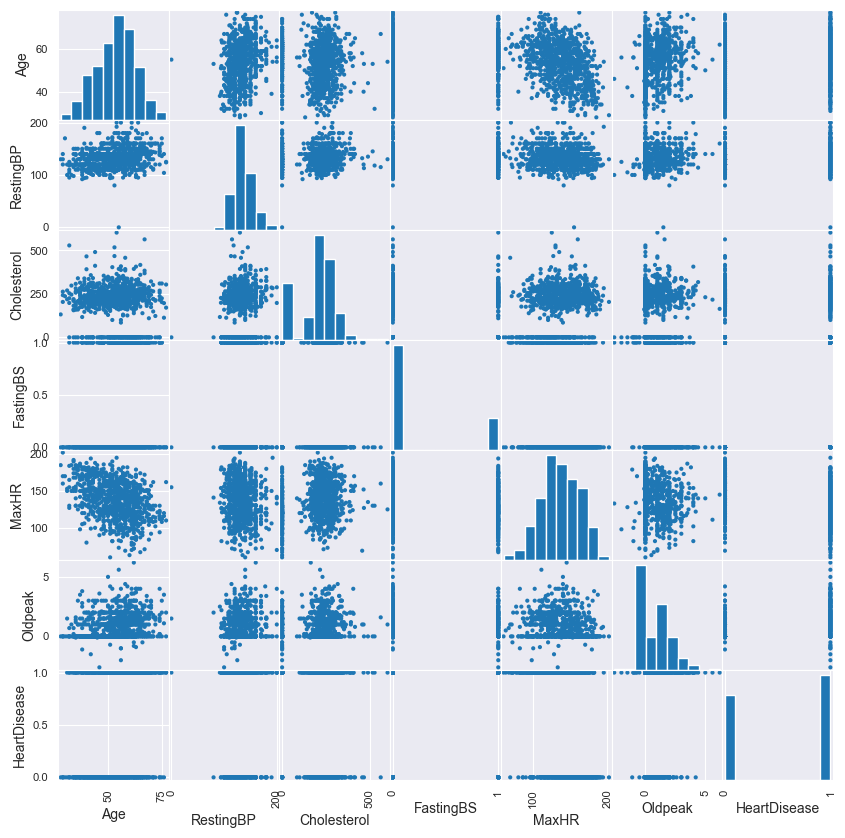

In [16]:
pd.plotting.scatter_matrix(data, figsize=(10, 10), alpha=1)
pass

# Борьба с выбросами
На диаграмме рассеивания можно заметить, что значения холестирина имеют много нулевых значений, а так же аномально высокие значения, к примеру 500. Заменим нулевые значения медианой, а сильно высокие и низкие удалим.

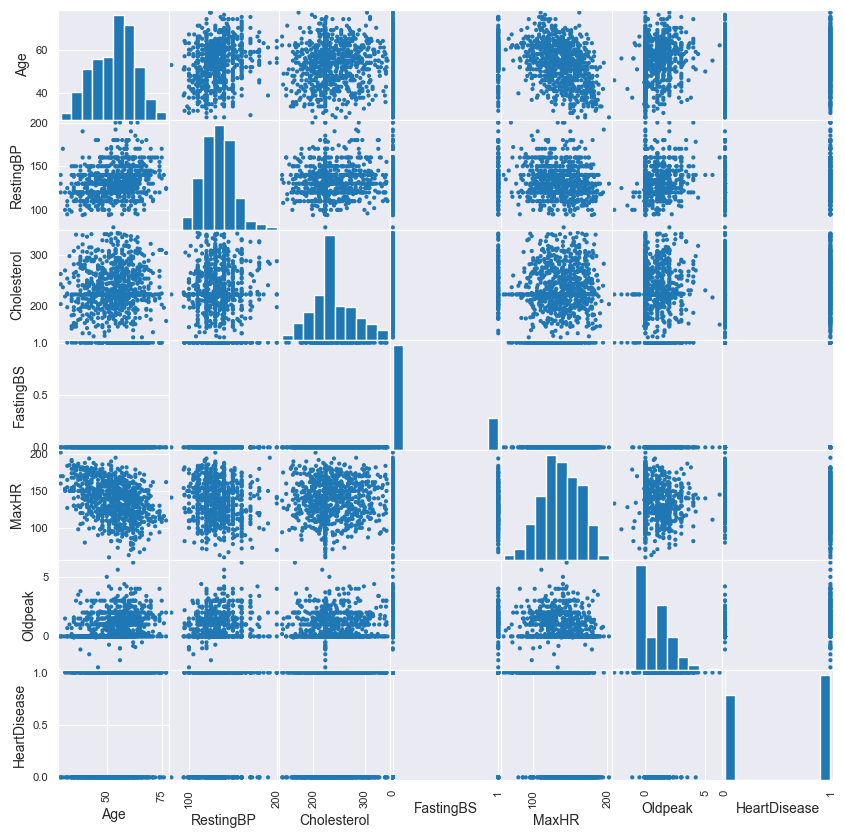

In [17]:
data[['RestingBP', 'Cholesterol']] = data[['RestingBP', 'Cholesterol']].replace(to_replace=0, value=data[['RestingBP', 'Cholesterol']].median(axis=0))
Q1, Q3 = data['Cholesterol'].quantile([.25, .75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
data = data.drop(data[(data['Cholesterol'] < lower) | (data['Cholesterol'] > upper)].index)
pd.plotting.scatter_matrix(data, figsize=(10, 10), alpha=1)
pass

# Коррелированные признаки

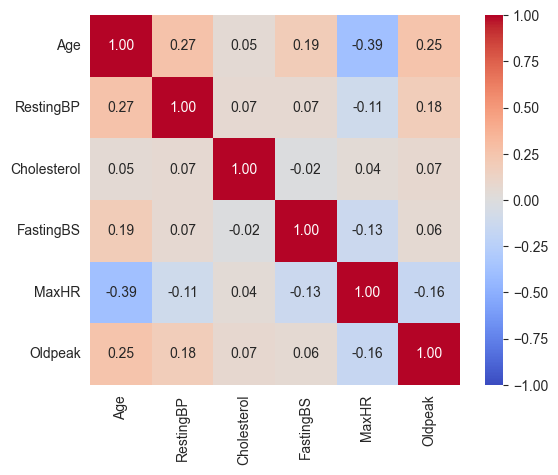

In [18]:
sns.heatmap(data.drop('HeartDisease', axis=1).corr(numeric_only=True), square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
pass

Можно заметить высокую зависимость между максимальным пульсом и возрастом, однако оба признака важны при анализе, поэтому не будем их удалять

# Обработка категориальных признаков. Балансировка классов. Масштабирование
Датасет содержит текстовые признаки, которые могут быть заменены на категориальные. Так же классы больных и здоровых людей не сбалансирваны, выполним балансировку. Сделаем стандартизацию данных, чтобы привести данные к одному виду и ускорить обучение


In [19]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

enc = OneHotEncoder(drop='if_binary', sparse=False)
enc.fit(X[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])
dummies = pd.DataFrame(enc.transform(X[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=enc.get_feature_names_out(), index=X.index)
X = pd.concat((X, dummies), axis=1).drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = smote.fit_resample(X, y)

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.387223,0.464714,1.293957,-0.517662,1.314435,-0.801001,0.542923,-1.016955,2.022066,-0.576451,-0.236844,-0.503419,0.812702,-0.494715,-0.777146,-0.273828,-0.946803,1.086677
1,-0.426914,1.607355,-1.381878,-0.517662,0.690122,0.157074,-1.914289,-1.016955,-0.517715,1.809501,-0.236844,-0.503419,0.812702,-0.494715,-0.777146,-0.273828,1.080900,-0.943887
2,-1.707327,-0.106607,1.146663,-0.517662,-1.573009,-0.801001,0.542923,-1.016955,2.022066,-0.576451,-0.236844,-0.503419,-1.266029,2.077622,-0.777146,-0.273828,-0.946803,1.086677
3,-0.533615,0.350449,-0.547214,-0.517662,-1.182814,0.636111,-1.914289,1.004408,-0.517715,-0.576451,-0.236844,-0.503419,0.812702,-0.494715,1.298688,-0.273828,1.080900,-0.943887
4,0.106591,1.036034,-1.013644,-0.517662,-0.636541,-0.801001,0.542923,-1.016955,-0.517715,1.809501,-0.236844,-0.503419,0.812702,-0.494715,-0.777146,-0.273828,-0.946803,1.086677


# Полносвзяный персептрон

In [20]:
model = keras.Sequential([
    keras.layers.Dense(18, activation='relu', input_shape=(18,)),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', metrics=keras.metrics.Recall(), loss=keras.losses.binary_crossentropy)
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
y_train_predict = [1 if i >= 0.5 else 0 for i in model.predict(X_train, verbose=0)]
y_test_predict = [1 if i >= 0.5 else 0 for i in model.predict(X_test, verbose=0)]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_predict, y_test)
cm1 = confusion_matrix(y_train_predict, y_train)
print(cm)
print('Test score:', cm.trace() / cm.sum())
print('Train score:', cm1.trace() / cm1.sum())

[[ 99  15]
 [ 25 104]]
Test score: 0.8353909465020576
Train score: 0.9339752407152683


# Метод ближайшего соседа

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

cm = confusion_matrix(y_test_predict, y_test)
cm1 = confusion_matrix(y_train_predict, y_train)
print(cm)
print('Test score:', cm.trace() / cm.sum())
print('Train score:', cm1.trace() / cm1.sum())

[[101  16]
 [ 23 103]]
Test score: 0.8395061728395061
Train score: 0.8940852819807428


# Случайный лес

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

cm = confusion_matrix(y_test_predict, y_test)
cm1 = confusion_matrix(y_train_predict, y_train)
print(cm)
print('Test score:', cm.trace() / cm.sum())
print('Train score:', cm1.trace() / cm1.sum())

[[103  13]
 [ 21 106]]
Test score: 0.8600823045267489
Train score: 1.0


# Поиск оптимальных гиперпараметров
Алгоритм случайного леса показал наилучший результат, поэтому оптимизируем кол-во деревьев.

In [23]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [x for x in range(100, 2001, 50)]}
model = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring='recall')
model.fit(X_train, y_train)
print(model.best_score_, model.best_params_)

0.8936690114772305 {'n_estimators': 350}


# График ошибки для разного числа деревьев

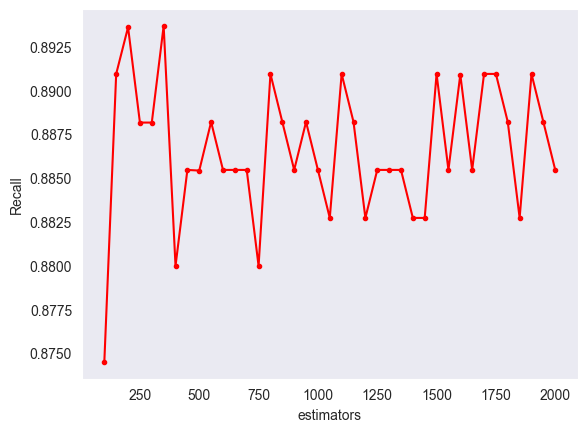

In [24]:
err_arr = model.cv_results_['mean_test_score']
k_arr = [x for x in range(100, 2001, 50)]
plt.plot(k_arr, err_arr, 'r.-')
plt.grid()
plt.xlabel('estimators')
plt.ylabel('Recall')
pass

# Случайный лес с новым гиперпараметром

In [25]:
model = RandomForestClassifier(n_estimators=model.best_params_['n_estimators'])
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

cm = confusion_matrix(y_test_predict, y_test)
cm1 = confusion_matrix(y_train_predict, y_train)
print(cm)
print('Test score:', cm.trace() / cm.sum())
print('Train score:', cm1.trace() / cm1.sum())

[[102  11]
 [ 22 108]]
Test score: 0.8641975308641975
Train score: 1.0


# Вывод
В результате обучения получили достаточно точный классификатор сердечно-сосудистых заболеваний. Случайный лес показал науилучшие результаты, knn и mlp имеют схожую точность.